In [67]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
fig_dim = (15,12)

Notas: A nossa solução inicial assumia que era possível fazer o tracing das bicicletas, mas após ser fornecido o dicionário, percebemos que tal não era possível dado que "The same bike can have multiple tags over the year".

In [2]:
base = '/home/ana/Downloads/'

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    return df

df = get_loans_clean(base)
df

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end
0,6501462,18701,1164,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0
1,6501318,41811,1089,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN
2,6501489,96620,1110,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0
3,6501001,16055,1465,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0
4,6501421,6431,996,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN
...,...,...,...,...,...,...,...,...,...
10387747,14454800,27944,2369,2019-12-31 13:58:55.000,2019-12-31 14:25:38.000,40,1,50.0,1.0
10387748,14454778,108800,2393,2019-12-31 13:52:48.000,2019-12-31 14:40:52.000,28,1,50.0,1.0
10387749,14454793,98449,60,2019-12-31 13:55:47.000,2019-12-31 14:41:39.000,113,1,28.0,1.0
10387750,14454774,129665,1829,2019-12-31 13:51:28.000,2019-12-31 16:27:12.000,39,15,41.0,15.0


Stations information

In [5]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','numSlots','isManual']]
df_info.head()

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1


Loans per station per hour

In [6]:
def get_loans_or_devolutions_per_station_per_hour(_df, field_date, field_station, field_position):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    df[field_date] = pd.to_datetime(df[field_date], format='%Y-%m-%d %H:%M:%S.%f')
    df[field_date] = df[field_date].dt.round("1H")
    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).count()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={field_position:'N Loans'})
    else:
        df = df.rename(columns={field_position:'N Devolutions'})
        
    return df

def get_loans_and_devolutions_info(_df):
    loans = get_loans_or_devolutions_per_station_per_hour(_df, \
                    'Start loan', 'ID start station', 'Position start')
    
    devolutions = get_loans_or_devolutions_per_station_per_hour(_df, \
                    'End loan', 'ID end station', 'Position end')
    
    df = pd.concat([loans, devolutions], axis=1)
    df = df.fillna(0)
    
    return df

loans_and_devolutions = get_loans_and_devolutions_info(df)
loans_and_devolutions.head(5)

N Loans  N Devolutions
Station Date                                       
0.0     2017-10-03 22:00:00      0.0            1.0
        2018-03-21 11:00:00      0.0            1.0
        2018-03-21 18:00:00      0.0            1.0
1.0     2016-01-04 06:00:00      5.0            1.0
        2016-01-04 07:00:00     11.0            2.0

In [7]:
# Given a station, this function calculates the number of bikes through time using the loans and the returns
def get_balance_for_station(_df, station):
    df = _df.copy()
    df = df.reset_index()
    df = df.loc[df['Station']==station]
    df['N Loans cumsum'] = df['N Loans'].cumsum()
    df['N Devolutions cumsum'] = df['N Devolutions'].cumsum() # returns
    df['Balance'] = df['N Devolutions cumsum'] - df['N Loans cumsum']
    
    return df

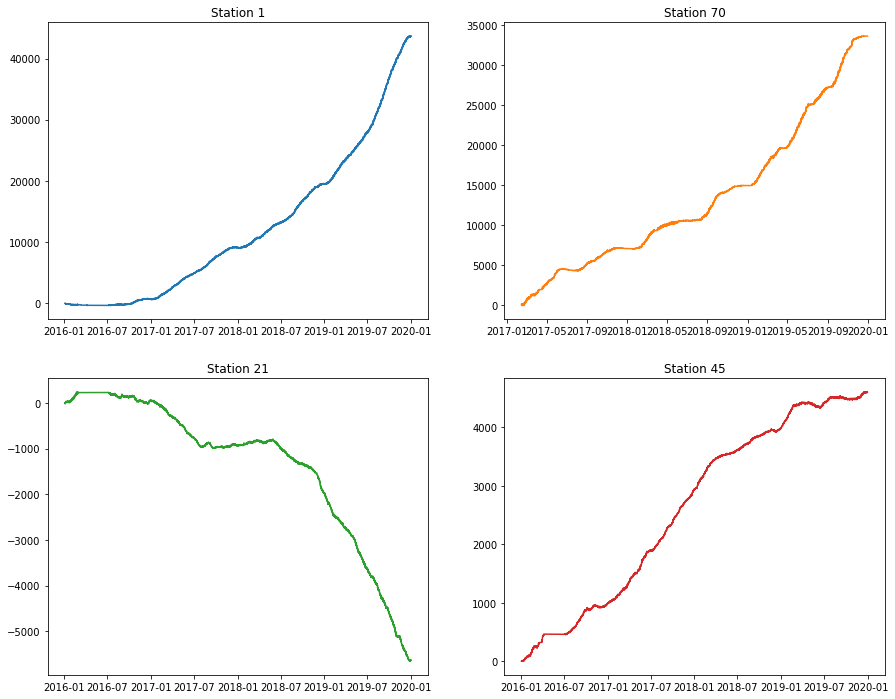

In [38]:
def plot_balance_over_multiple_stations(stations):
    
    fig, axs = plt.subplots(2, 2, figsize=fig_dim)
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1] ]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i in range(4):
        station = stations[i]
    
        balance_st = get_balance_for_station(loans_and_devolutions, station)
        
        axis[i].plot(balance_st['Date'], balance_st['Balance'], colors[i])
        axis[i].set_title('Station ' + str(station))

    plt.plot()

plot_balance_over_multiple_stations(stations=[1, 70, 21, 45])

Obter o número inicial de bicicletas por estação

In [56]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    df = df.rename(columns={'Tag ID':'Count'})
    df = df.sort_values(by=['Count'])
    df = df.reset_index()
    df["ID start station"] = df["ID start station"].astype(str)
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.head()

,ID start station,Count
0,89,1
1,96,1
2,99,1
3,25,1
4,106,1


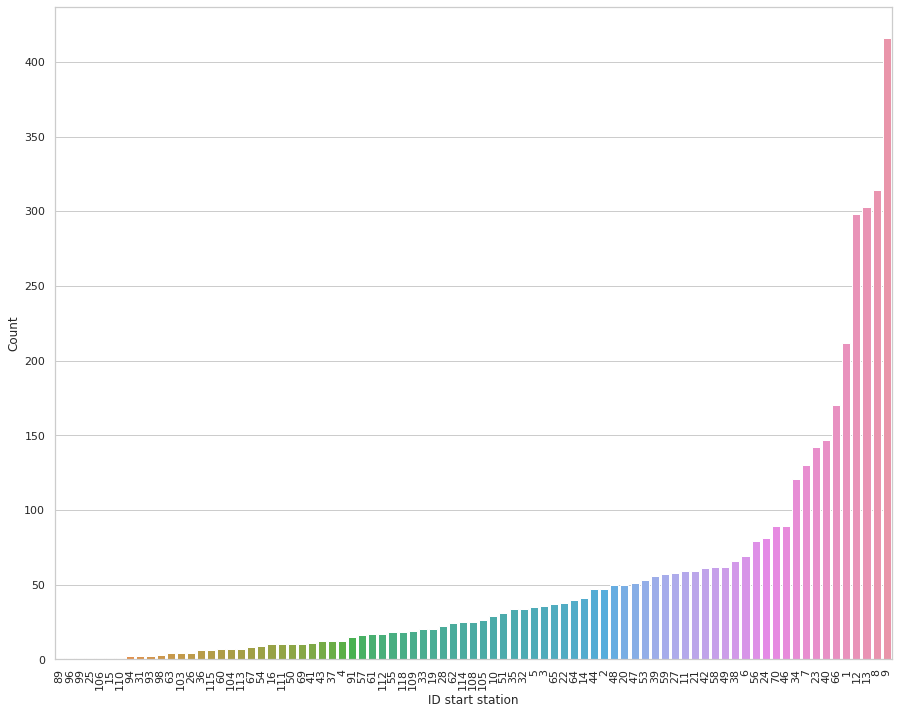

In [70]:
fig, axs = plt.subplots(figsize=fig_dim)
axs = sns.barplot(x="ID start station", y="Count", data=init_n_bikes)
plt.xticks(rotation=90)
plt.draw()

The figure above represents the number of bikes that appear for the first time in each station

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

In [ ]:
def occupation_tax(nPos, maxPos):
    return (nPos*100)/maxPos

In [ ]:
df.columns

Ver a taxa de ocupação a cada hora

In [77]:
df_info

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1
...,...,...,...
102,138,36,0
103,139,40,0
104,140,40,0
105,141,52,0


Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?

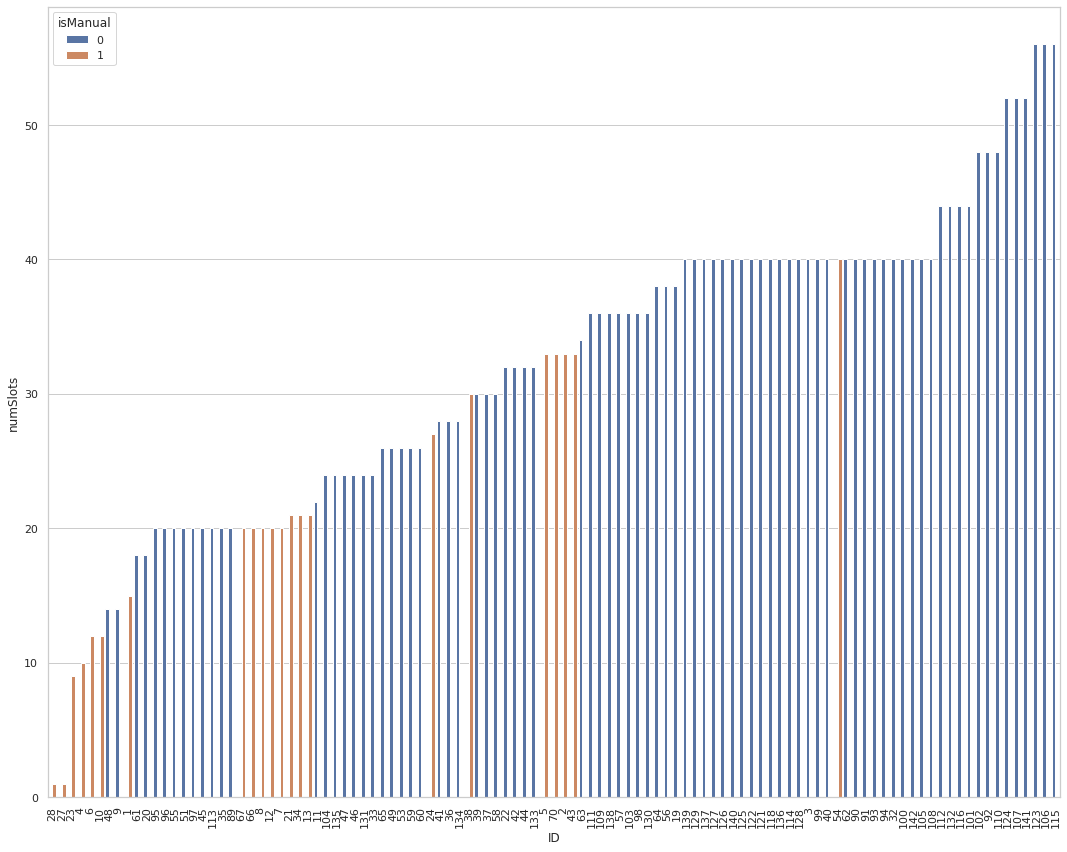

In [78]:
def capacity_per_station(_df):
    df = _df.copy()
    df["ID"] = df["ID"].astype(str)
    df = df.sort_values(by=['numSlots'])
    
    fig, axs = plt.subplots(figsize=(15,12))
    axs = sns.barplot(x="ID", y="numSlots", hue="isManual", data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.draw()
    
capacity_per_station(df_info)